## 02_Preprocessing

**Description:** Loading in subreddit post data, conducting some general Exploratory Data Analysis (EDA), and readying the data for fitting models.

In [3]:
import json
import pandas as pd
import csv
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction import stop_words
from nltk.tokenize import RegexpTokenizer

**Loading in Reddit Posts**

In [5]:
with open('../data/nto_t.pkl', 'rb') as f:
    nto_t = pickle.load(f)
with open('../data/to_t.pkl', 'rb') as f:
    to_t = pickle.load(f)

**Deleting Duplicates & Merging Titles into single DataFrame**

In [8]:
nto_t.drop_duplicates(inplace=True)
to_t.drop_duplicates(inplace=True)
nto_t.info(), to_t.info()

In [9]:
nto_t.head()

,Title,sub
0,"Snapchat map mislabeled New York City as ""Jewt...",1
1,Baby Mayor Kahn balloon to fly over Parliament...,1
2,"Love Lorn Dolphin ""Zafar"" Causes French Beach Ban",1
3,Permission denied for PETA to honor dead lobst...,1
4,This guy wanted his head to look like a skull,1


In [10]:
to_t.head()

,Title,sub
0,NASCAR Race Stops To Wait For Family Of Ducks ...,0
1,Evolution Definitively Proven As Scientists Ca...,0
2,Trump Disapproval Rating Reaches All-Time None...,0
3,Trump Teeters On White House Ledge Weighing Pr...,0
4,Eminem Horrified Upon Being Informed That ‘Fag...,0


In [11]:
df = pd.concat([nto_t, to_t], ignore_index=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8806 entries, 0 to 8805
Data columns (total 2 columns):
Title    8806 non-null object
sub      8806 non-null int64
dtypes: int64(1), object(1)
memory usage: 137.7+ KB


**Pickling Merged DataFrame - Just in Case**

In [26]:
# with open('../data/df.pkl', 'wb') as f:
#     pickle.dump(df, f)

### EDA

**Getting Rid of Punctuation**

In [30]:
titles = [re.sub("[^a-zA-Z]"," ",title) for title in df['Title']]

**Preprocessing via NLTK**

In [33]:
tokenizer = RegexpTokenizer(r'\w+')
title_tokens = [tokenizer.tokenize(title.lower()) for title in titles]
df['tokens'] = title_tokens

**Overview of My Dataset**

In [36]:
all_words = []

for title in title_tokens:
    for t in title:
        all_words.append(t)

In [37]:
VOCAB = set(all_words)

In [130]:
df['length'] = [len(title) for title in df['Title']]

In [131]:
df.head()

,Title,sub,tokens,length
0,"Snapchat map mislabeled New York City as ""Jewt...",1,"[snapchat, map, mislabeled, new, york, city, a...",54
1,Baby Mayor Kahn balloon to fly over Parliament...,1,"[baby, mayor, kahn, balloon, to, fly, over, pa...",51
2,"Love Lorn Dolphin ""Zafar"" Causes French Beach Ban",1,"[love, lorn, dolphin, zafar, causes, french, b...",49
3,Permission denied for PETA to honor dead lobst...,1,"[permission, denied, for, peta, to, honor, dea...",74
4,This guy wanted his head to look like a skull,1,"[this, guy, wanted, his, head, to, look, like,...",45


In [38]:
print("My dataset consists of {} words, and a unique vocabulary of {} words".format(len(all_words), len(VOCAB)))

My dataset consists of 119331 words, and a unique vocabulary of 15102 words


In [134]:
df['length'].mean(), df['length'][df['sub'] == 1].mean(), df['length'][df['sub'] == 0].mean()

(80.49954576425165, 72.08590308370044, 87.78305084745763)

**Further Analysis**

With 8806 headlines, that gives us an average word count of ~13.55 per headline, and an average character count of ~80.6. Interstingly enough, the average character length is quite different between The Onion, and non-Onion headlines. Non-Onion headlines average ~15 fewer characters compared to The Onion. Hopefully this will help my model differentiate between sensational and satirical posts.

**Examining General Word Counts**

In [39]:
cv = CountVectorizer()

In [40]:
cv.fit(all_words)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [41]:
word_vector = cv.transform(all_words)

In [42]:
word_df = pd.DataFrame(word_vector.toarray(), columns=cv.get_feature_names())

In [43]:
word_counts = word_df.sum(axis=0)

**Highest Count Words (without Stop Words)**

In [44]:
word_counts.sort_values(ascending=False).head(25)

to       3784
the      2483
of       2316
in       1878
for      1371
on       1052
and      1051
with      889
is        770
after     697
man       635
out       614
that      603
trump     600
by        588
it        583
have      566
you       557
at        547
what      530
this      528
his       518
from      497
he        496
new       462
dtype: int64

It appears that most of my particularly common words would also be stop words as well. I'll try running this listing against my list of stop words, to see if I'm able to get a more informative list

**Word Counts (with Stop Words)**

In [45]:
cv_s = CountVectorizer(stop_words='english')

word_vector_stop = cv_s.fit_transform(all_words)

word_df_s = pd.DataFrame(word_vector_stop.toarray(), columns=cv_s.get_feature_names())
word_counts_stop = word_df_s.sum(axis=0)

In [135]:
wc = word_counts_stop.sort_values(ascending=False).head(25)
wc

man          635
trump        600
new          462
life         416
say          391
news         359
just         315
woman        305
says         266
police       243
said         219
people       218
year         214
old          202
video        185
like         172
white        170
report       163
day          150
time         150
sex          148
house        148
questions    143
years        143
know         139
dtype: int64

In [69]:
index_list = list(wc.index)

In [111]:
wc_df = pd.concat([wc, pd.Series(index_list, index=wc.index)], axis=1)
wc_df.rename({0:'Count', 1:'Term'}, axis=1, inplace=True)

**Visualizing Word Counts (with Stop Words)**

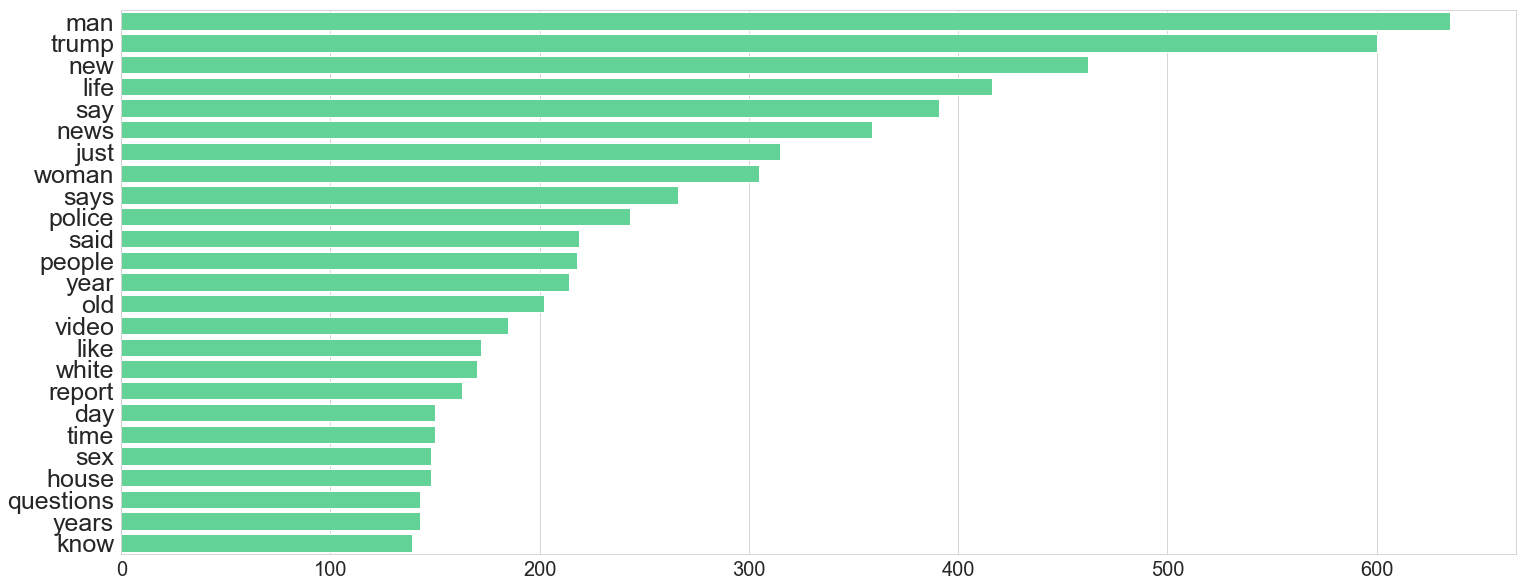

In [125]:
sns.set_style("whitegrid")
plt.figure(figsize=(25,10))
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
sns.barplot(data=wc_df, x='Count', y='Term', orient='h', color='#63d297', saturation=1)
plt.xlabel(s='')
plt.ylabel(s='')
# plt.savefig('../images/top_terms.png')

This listing feels like what you'd see in a 'most popular news stories feature these words' list. That is, what you'd see with the inclusion of terms like "trump", "police", and "sex" (i.e., subjects that may be polarizing). Beyond those words, we see common english nouns like 'man', 'woman', 'video', 'people', etc. What's most surprising about this list is the inclusion of "news". I'm curious to know what the most common contextual uses for that word in these headlines are.

**Creating Target Variable**

In [21]:
target = df['sub']

### Initializing Vectorizer

I plan on creating two vectorizers that will actually be run into my model. One featuring an `ngram_range` of (1,1), and another with a range of (1,2), to see if incorporating any phrasing assists in the accuracy of my model. Given the size of each post I'm looking at (~13.55 words), I wouldn't *assume* that there would be much to clean from an increased range, though I don't think it'll hurt to try.

In [20]:
tfidf = TfidfVectorizer(stop_words='english', min_df=5, max_df=1.0)
tfidf_2 = TfidfVectorizer(stop_words='english', min_df=5, max_df=1.0, ngram_range=(1, 2))

A minimum document frequency of 5 seems like a good starting point. I'll consider coming back and re-Vectorizing if my model scores are unsatisfactory.

In [22]:
term_mat = tfidf.fit_transform(df['Title'])
term_mat_2 = tfidf_2.fit_transform(df['Title'])

In [23]:
len(tfidf.get_feature_names()), len(tfidf_2.get_feature_names())

(3488, 4168)

Both of these numbers seem like an awful lot of features given the size of my dataset. While I still plan on modeling based off of the full datasets, I'll toss my smallest matrix through SVD to retreive the most important values. I believe this will lead to more accurate predictions.

**Tossing Vectorizers into DataFrame**

In [24]:
term_df = pd.SparseDataFrame(term_mat, columns=tfidf.get_feature_names())
term_df_2 = pd.SparseDataFrame(term_mat_2, columns=tfidf_2.get_feature_names())

In [25]:
term_df.fillna(0, inplace=True)
term_df_2.fillna(0, inplace=True)

### Initialize SVD

In [137]:
SVD = TruncatedSVD(n_components=1000)
svd_matrix = SVD.fit_transform(term_df)
svd_matrix.shape

(8806, 1000)

In [138]:
SVD.explained_variance_ratio_.sum()

0.6691644210249765

Text(0.5,1,'Explained variance by component')

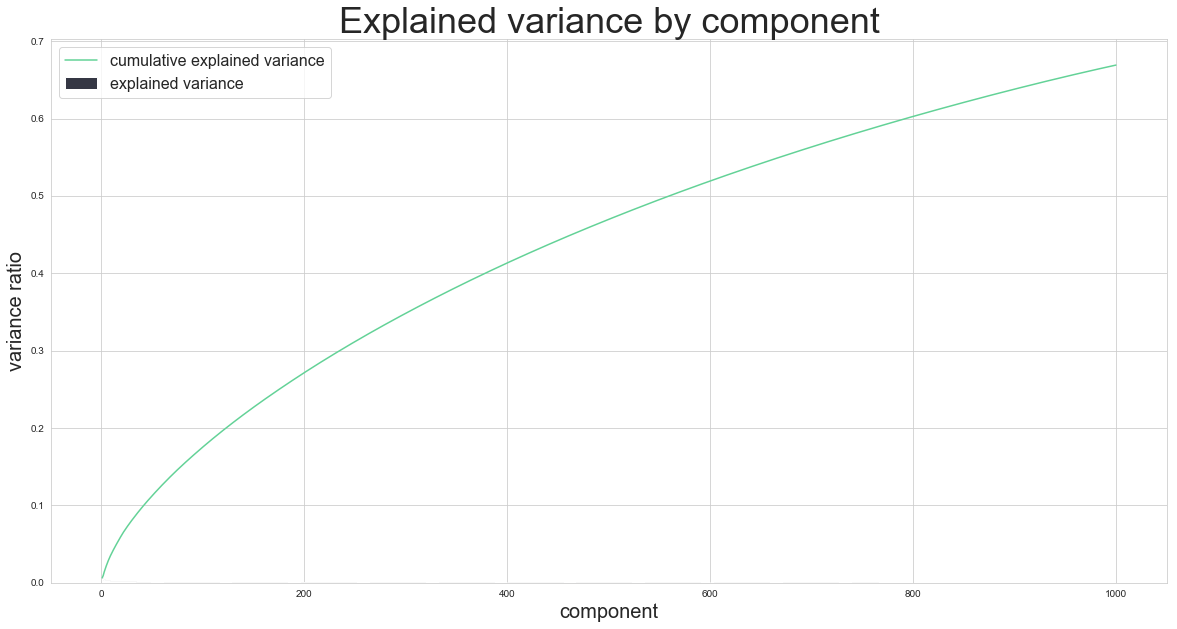

In [152]:
fig = plt.figure(figsize=(20,10))
plt.bar(np.array(range(1000))+1, 
        SVD.explained_variance_ratio_, 
        color='#353744', 
        label='explained variance')
plt.plot(np.array(range(1000))+1, 
         np.cumsum(SVD.explained_variance_ratio_), 
         label='cumulative explained variance',
         color='#63d297')
plt.legend(fontsize=16)
plt.xlabel('component', fontsize=20)
plt.ylabel('variance ratio', fontsize=20)
plt.title('Explained variance by component', fontsize=36);

It seems as though every feature explains a minute amount of variance within the entire dataset. Given the similarity with which The Onion and non-Onion (yet still quite crazy sounding) headlines happen to have, this isn't entirely surprising, though I didn't expect that not a single component would explain even 3% of the variance. I can't even visualize a single components variance on this plot.

In [140]:
component_names = ["component_"+str(i+1) for i in range(1000)]
svd_df = pd.DataFrame(svd_matrix, columns=component_names)

In [141]:
svd_df.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_991,component_992,component_993,component_994,component_995,component_996,component_997,component_998,component_999,component_1000
0,0.017320,0.081088,-0.033523,0.121732,0.229534,-0.055085,0.197614,0.060284,0.064098,-0.029800,...,-0.000216,-0.002674,0.000542,0.003332,0.008224,0.011224,-0.003348,0.005984,-0.001116,0.001033
1,0.005344,0.018737,-0.006767,-0.008445,-0.006199,-0.000997,0.002856,0.010173,-0.000499,0.001821,...,-0.027166,0.006235,0.010438,-0.014116,0.004088,-0.004582,0.018274,0.058928,-0.007357,-0.026311
2,0.005228,0.020008,-0.006038,0.007440,0.003707,-0.001170,-0.007097,0.003212,-0.012215,0.002708,...,-0.006812,0.007857,-0.006777,-0.028442,-0.011210,0.030824,0.002039,-0.016571,0.000525,0.017298
3,0.006595,0.024682,-0.009843,0.002697,-0.000422,-0.000586,-0.003821,-0.006777,-0.013209,-0.000254,...,-0.011769,-0.017549,0.013274,-0.001593,-0.013449,-0.006480,-0.011589,0.028038,0.016760,-0.001084
4,0.018271,0.071394,-0.015829,0.013938,0.018760,0.001742,-0.034628,-0.030071,-0.060521,-0.023220,...,0.005764,-0.013865,0.001626,0.013951,0.005837,0.007059,-0.003498,-0.001995,-0.002202,-0.014757


It's hard to see what each of these features is really made of. I'll put together a feature loadings matrix to help me understand the makeup of each component.

## Creating Feature Loadings Matrix

In [142]:
loadings = pd.DataFrame(SVD.components_,
                        index=component_names,
                        columns=term_df.columns).T

In [143]:
loadings['abs_component_1'] = np.abs(loadings.component_1)
loadings['abs_component_2'] = np.abs(loadings.component_2)

In [144]:
loadings.tail()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_993,component_994,component_995,component_996,component_997,component_998,component_999,component_1000,abs_component_1,abs_component_2
zinke,0.000322,0.001060,0.000397,0.000070,0.000200,-0.000113,-0.000215,0.000286,-0.000819,-0.000164,...,-0.012286,0.009932,0.017075,-0.003977,0.025984,0.019856,0.005768,-0.012622,0.000322,0.001060
zone,0.001770,0.003020,-0.003010,-0.001675,-0.000783,0.003121,0.000812,-0.001065,-0.002768,0.001305,...,0.012809,-0.017175,0.006893,-0.013951,-0.012542,0.014962,-0.011433,-0.008704,0.001770,0.003020
zones,0.000833,0.005813,0.007466,-0.000790,-0.001503,-0.000006,0.000150,-0.002050,0.000225,0.000473,...,-0.001865,-0.012030,-0.005655,-0.027143,-0.010582,0.012798,-0.007162,0.008478,0.000833,0.005813
zoo,0.003133,0.015110,-0.014347,-0.006081,-0.004274,-0.000717,0.004769,-0.008825,-0.004532,-0.004415,...,0.012941,-0.003587,0.004559,0.027038,-0.029392,-0.009076,0.004214,-0.028668,0.003133,0.015110
zuckerberg,0.008379,0.004679,-0.001334,0.004667,0.004102,0.000294,-0.007591,-0.005425,-0.010198,0.023855,...,-0.001869,-0.004911,-0.006437,-0.000369,-0.007698,-0.009828,0.004981,0.007327,0.008379,0.004679


**Looking at Individual Components**

In [145]:
loadings.sort_values('abs_component_1',ascending=False).head(20)[['component_1']]

,component_1
say,0.694569
said,0.644676
man,0.101917
trump,0.073660
police,0.070640
david,0.067068
james,0.065816
just,0.045089
new,0.043757
john,0.041873


In looking at the first component, it would seem as though lemmatizing (or at least stemming), could assist in consolidating some well-used vocabulary. Nonetheless, I don't plan on going back and lemmatizing unless my model performs poorly.

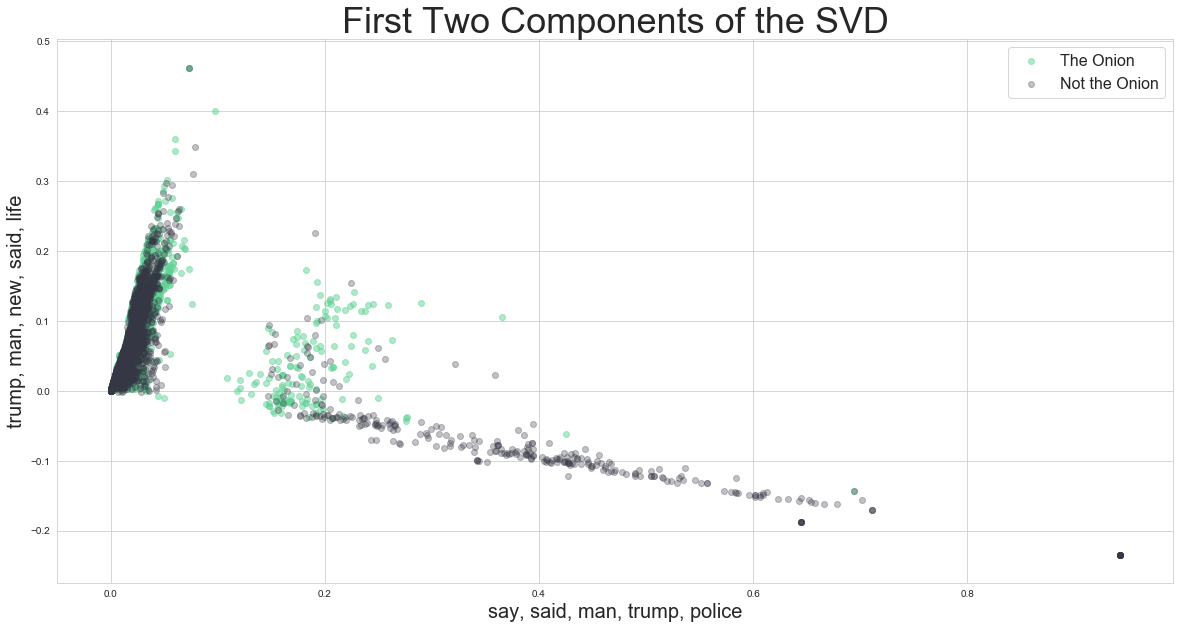

In [150]:
plt.figure(figsize=(20,10))
plt.scatter(svd_df.component_1[target==1], svd_df.component_2[target==1], c='#63d297', alpha=.5)
plt.scatter(svd_df.component_1[target==0], svd_df.component_2[target==0], c='#353744', alpha=.3)
plt.xlabel(f"{', '.join(loadings.sort_values('abs_component_1',ascending=False).head(5)[['component_1']].index)}",
          fontsize=20)
plt.ylabel(f"{', '.join(loadings.sort_values('abs_component_2',ascending=False).head(5)[['component_2']].index)}",
          fontsize=20)
plt.title('First Two Components of the SVD', fontsize=36)
plt.legend(['The Onion', 'Not the Onion'], fontsize=16)

Looking at the orthogonal relationship between the first two components of my SVD, I'm not super confident that my model will be able to accurately delineate between Onion and non-Onion headlines. If the first two components, which explain more of the variance within the dataset than any other two compontets, are largely similar for a majority of values within my datset, it wouldn't seem like they would lend well to making accurate predictions.

**Pickling components of my Dataset for Modeling**

In [28]:
with open('../pickle/tfidf_2.pkl', 'wb') as f:
    pickle.dump(tfidf_2, f)
with open('../pickle/term_df.pkl', 'wb') as f:
    pickle.dump(term_df, f)
with open('../pickle/term_df_2.pkl', 'wb') as f:
    pickle.dump(term_df_2, f)
with open('../pickle/svd_df.pkl', 'wb') as f:
    pickle.dump(svd_df, f)
with open('../pickle/target.pkl', 'wb') as f:
    pickle.dump(target, f)

**Go To: 03_modeling**